In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib

# other
import sklearn
import fairlearn

# this tutorial has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.24.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.3.2   Your version: %s" % sklearn.__version__)
print("fairlearn     Tested version: 0.10.0  Your version: %s" % fairlearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.0.3
numpy         Tested version: 1.24.5  Your version: 1.24.4
matplotlib    Tested version: 3.5.3   Your version: 3.5.1
scikit-learn  Tested version: 1.3.2   Your version: 1.2.1
fairlearn     Tested version: 0.10.0  Your version: 0.10.0


In [2]:
# import functionality
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, make_derived_metric
from sklearn.metrics import precision_score
from fairlearn.metrics import selection_rate, count, false_positive_rate, false_negative_rate
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.calibration import CalibrationDisplay

In [3]:
# load data
data = pd.read_csv('compas-scores-two-years.csv')
# filter similar to propublica
data = data[(data['days_b_screening_arrest'] <= 30) &
                (data['days_b_screening_arrest'] >= -30) &
                (data['is_recid'] != -1) &
                (data['c_charge_degree'] != "O") &
                (data['score_text'] != "N/A")]
# select columns
data = data[['sex', 'age', 'race', 'priors_count', 'decile_score', 'two_year_recid']]
# cut-off score 5 
data['decile_score_cutoff']= data['decile_score'] >= 5
# inspect
data.head()

,sex,age,race,priors_count,decile_score,two_year_recid,decile_score_cutoff
0,Male,69,Other,0,1,0,False
1,Male,34,African-American,0,3,1,False
2,Male,24,African-American,4,4,1,False
5,Male,44,Other,0,1,0,False
6,Male,41,Caucasian,14,6,1,True


In [4]:
# compute metrics by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
# print results
display(mf.by_group)
print("Overall SR: %.2f" % mf.overall[0])

# summarize demographic parity as the max difference between groups
print("demographic parity diff: %.2f" % mf.difference(method='between_groups')[0])

# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(y_true=data['two_year_recid'], 
                                    y_pred=data['decile_score_cutoff'], 
                                    sensitive_features=data['race'], 
                                    method='between_groups') # summarize as the max difference between any of the groups
print("demographic parity diff: %.2f" % dpd)

,selection rate (COMPAS)
race,
African-American,0.576063
Asian,0.225806
Caucasian,0.330956
Hispanic,0.277014
Native American,0.727273
Other,0.204082


Overall SR: 0.45
demographic parity diff: 0.52
demographic parity diff: 0.52


In [5]:
# number of instances in each racial category
display(data['race'].value_counts())

# we can also include count as a metric in MetricFrame
mf = MetricFrame(metrics={'count' : count}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
display(mf.by_group)

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

,count
race,
African-American,3175
Asian,31
Caucasian,2103
Hispanic,509
Native American,11
Other,343


,0.025,0.975
,selection rate (COMPAS),selection rate (COMPAS)
race,,
African-American,0.560148,0.590021
Asian,0.082296,0.363561
Caucasian,0.315466,0.350783
Hispanic,0.242634,0.314458
Native American,0.492424,1.000000
Other,0.169057,0.250043


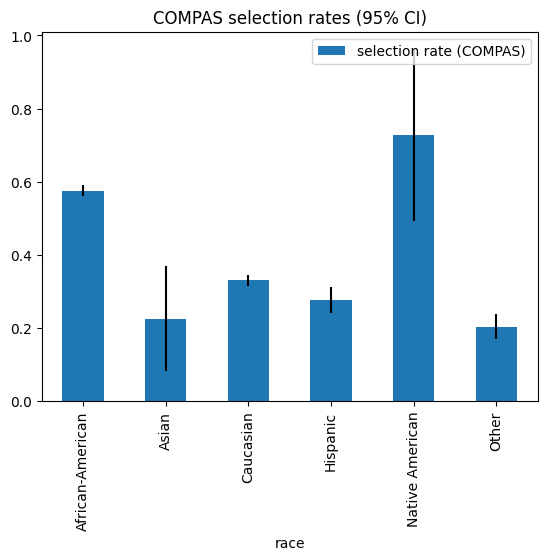

demographic parity diff: 0.52 (95 CI [0.38, 0.82])


In [6]:
# compute metrics by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'],
                 n_boot=100,
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42)

# display quantiles
errors = pd.concat(mf.by_group_ci, keys=mf.ci_quantiles, axis=1)
display(errors)

# plot errorbars
# matplotlib requires errorbars to be supplied as the size of the errorbar
errors['size min'] = mf.by_group - errors.loc[:,0.025]
errors['size max'] = errors.loc[:,0.975] - mf.by_group
mf.by_group.plot(kind='bar', yerr=[errors['size min'], errors['size max']])
plt.title("COMPAS selection rates (95% CI)")
plt.show()

# print confidence interval of maximum demographic parity difference
dpd = mf.difference()
dpd_ci = mf.difference_ci()
print("demographic parity diff: %.2f (95 CI [%.2f, %.2f])" % (dpd.iloc[0], dpd_ci[0].iloc[0], dpd_ci[1].iloc[0]))

In [7]:
# select two largest groups
data = data[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]

In [8]:
# compute selection rate by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'],
                 n_boot=100,
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42)
display(mf.by_group)

# print confidence interval of maximum demographic parity difference
dpd = mf.difference()
dpd_ci = mf.difference_ci()
print("demographic parity diff: %.2f (95 CI [%.2f, %.2f])" % (dpd.iloc[0], dpd_ci[0].iloc[0], dpd_ci[1].iloc[0]))

# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(metrics={'base rate' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['two_year_recid'], 
                 sensitive_features=data['race'],
                 n_boot=100, 
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42,
                )
display(mf.by_group)

# max base rate difference between groups
bpd = mf.difference()
bpd_ci = mf.difference_ci()
print("base rate diff: %.2f (95 CI [%.2f, %.2f])" % (bpd.iloc[0], bpd_ci[0].iloc[0], bpd_ci[1].iloc[0]))

,selection rate (COMPAS)
race,
African-American,0.576063
Caucasian,0.330956


demographic parity diff: 0.25 (95 CI [0.22, 0.27])


,base rate
race,
African-American,0.52315
Caucasian,0.39087


base rate diff: 0.13 (95 CI [0.11, 0.16])


In [9]:
# compute metrics
mf = MetricFrame(metrics = 
                 {'false positive rate' : false_positive_rate,
                  'false negative rate' : false_negative_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data[['race']])
display(mf.by_group)

# summarize differences
for i in mf.difference('between_groups').items():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(data['two_year_recid'], 
                                    data['decile_score_cutoff'], 
                                    sensitive_features=data['race'], 
                                    method='between_groups')
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
race,,
African-American,0.423382,0.284768
Caucasian,0.220141,0.496350


false positive rate diff: 0.20
false negative rate diff: 0.21
equalized odds diff: 0.21


In [10]:
def negative_predictive_value_score(y_true, y_pred, **kwargs):
    """
    NPV is not in scikit-learn, but is the same as PPV but with 0 and 1 swapped. 
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

# compute metrics
mf = MetricFrame(metrics = 
                 {'positive predictive value' : precision_score,
                  'negative predictive value' : negative_predictive_value_score}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
display(mf.by_group)

# summarize differences
for i in mf.difference('between_groups').items():
    print("%s diff: %.2f" % i)

# we can also define a custom fairness metric for npv (giving the same results as mf.differnece())
npv_score_diff = make_derived_metric(metric=negative_predictive_value_score, transform='difference')
npvd = npv_score_diff(data['two_year_recid'], 
                    data['decile_score_cutoff'], 
                    sensitive_features=data['race'], 
                    method='between_groups')
print("npv diff: %.2f" % npvd)

,positive predictive value,negative predictive value
race,,
African-American,0.649535,0.648588
Caucasian,0.594828,0.710021


positive predictive value diff: 0.05
negative predictive value diff: 0.06
npv diff: 0.06


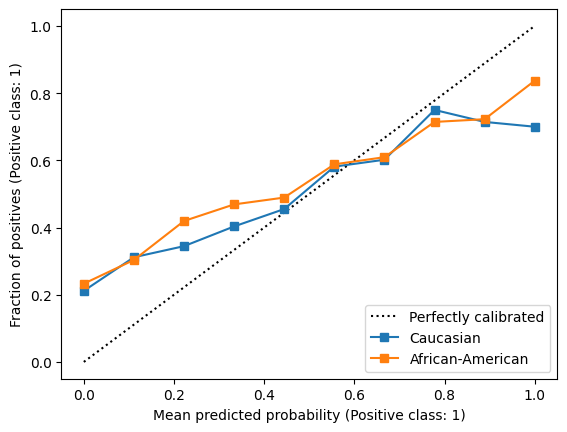

In [11]:
# normalize predicted scores to from 0 to 1
data['decile_score_norm'] = (data['decile_score'] - 1)/9

# display calibration curves
ax = plt.gca()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for race in ['Caucasian', 'African-American']:
    CalibrationDisplay.from_predictions(y_true=data[data['race']==race]['two_year_recid'], 
                                        y_prob=data[data['race']==race]['decile_score_norm'],
                                        n_bins=10,
                                        ax=ax, 
                                        label=race)
plt.show()